In [1]:
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils

using Interpolations
using LinearAlgebra
using SparseArrays

# Plots
using CairoMakie
using Colors
pathof(QuantumCollocation)

"/home/andy/Documents/Research/JuliaPackages/StealthPICO/src/QuantumCollocation.jl"

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;

In [3]:
# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}(I, 2, 2),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 -im; im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)
const a = [0 1; 0 0]
const ad = transpose(a);

In [4]:
excitation(theta) = exp(-im/2 * theta * (Paulis["Z"]))

excitation (generic function with 1 method)

In [5]:
H_drift = [ ]
H_drives = [
     a + ad,
     im * (a - ad),
]
system = QuantumSystem(H_drives);

# Times
t_f = 10 * ns
n_steps = 51
times = range(0, t_f, n_steps)
Δt = times[2] - times[1]

0.2

# Inspect previous results

In [6]:
trajs = []
for i in 1:10
    push!(trajs, load_traj("playground/AndySamples/data_point_$i.jld2"))
end

θs = range(0,pi/5,10)
excitation(θs[end])

2×2 Matrix{ComplexF64}:
 0.951057-0.309017im       0.0+0.0im
      0.0+0.0im       0.951057+0.309017im

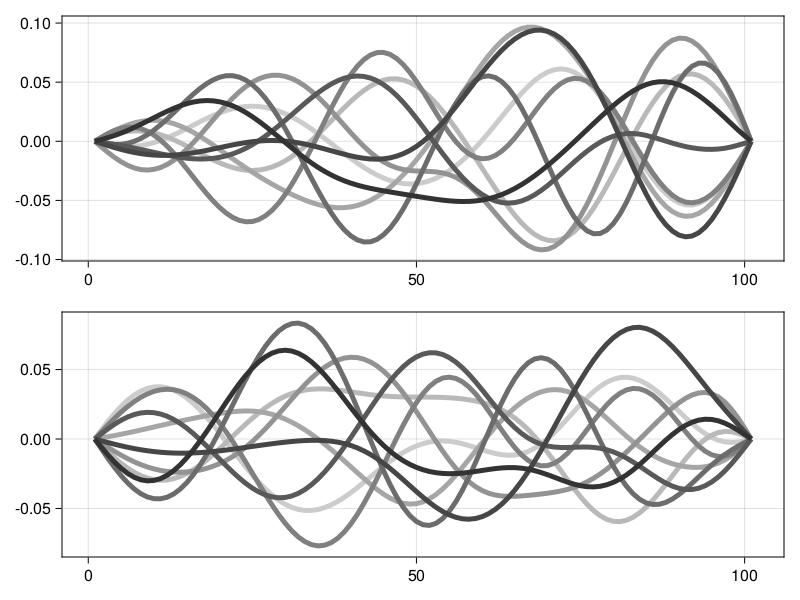

In [7]:
Δas = []
for (a, b) in zip(trajs[1:end-1], trajs[2:end])
    push!(Δas, b[:a] - a[:a])
end
Δas[1]

f = Figure()
ax = Axis(f[1, 1])
ax1 = Axis(f[2, 1])
# ten-color gradient from light to dark
colors = reverse([HSV(0.0, 0.0, i) for i in range(0.2, 0.8, length(Δas))])
for (i, Δa) in enumerate(Δas)
    lines!(ax, Δa[1, :], color=colors[i], linewidth=5)
    lines!(ax1, Δa[2, :], color=colors[i], linewidth=5)
end
f

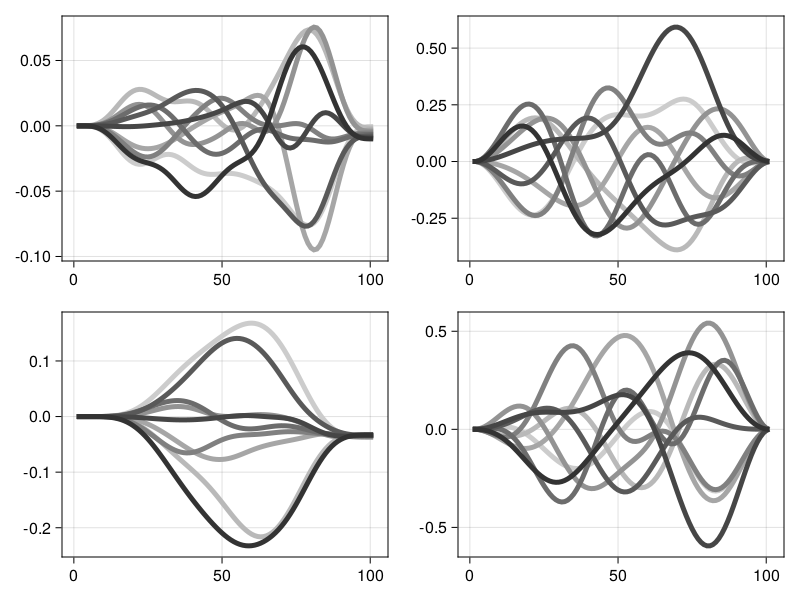

In [8]:
ΔUs = []
for (a, b) in zip(trajs[1:end-1], trajs[2:end])
    push!(ΔUs, b[:Ũ⃗] - a[:Ũ⃗])
end
Δas[1]

f = Figure()
axes = [Axis(f[1, 1]), Axis(f[1, 2]), Axis(f[2, 1]), Axis(f[2, 2])]
# ten-color gradient from light to dark
colors = reverse([HSV(0.0, 0.0, i) for i in range(0.2, 0.8, length(ΔUs))])
for (i, ΔU) in enumerate(ΔUs)
    for j in 1:4
        lines!(axes[j], ΔU[j, :], color=colors[i], linewidth=5)
    end
end
f

# Generate new results

In [6]:
# Shape the cost function with weights on states and controls
Q = 100.
R = 1e-4

# Add control bounds
a_bound = 2 * π * 100 * MHz
dda_bound = 0.1 # GHz / ns^2
initial_θs = range(0, 2*π, 10)
initial_infidelities = []
initial_trajectories = []
initial_probs = []

ops = Options()
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1e-3
ops.print_level = 2

for θ ∈ initial_θs
    print("\nAngle $θ\n")
    target = excitation(θ)

    U_guess = nothing
    a_guess = nothing
    if(length(initial_trajectories) > 0)
        U_guess = initial_trajectories[end][:Ũ⃗]
        a_guess = initial_trajectories[end][:a]
    end

    p = UnitarySmoothPulseProblem(
        system,
        target,
        n_steps,
        Δt;
        a_guess=a_guess,
        a_bound=a_bound,
        dda_bound=dda_bound,
        Q=Q,
        R=R,
        verbose=false,
        hessian_approximation=true,
        pade_order=10,
        free_time=false,
        timesteps_all_equal=true,
        ipopt_options=ops,
    )
    println("Solving...")
    solve!(p; max_iter=200)
    infid_θ = 1 - unitary_fidelity(p)
    println("\tInfidelity: $infid_θ\n")
    push!(initial_infidelities, infid_θ)
    push!(initial_trajectories, copy(p.trajectory))
    push!(initial_probs, p)
end




Angle 0.0
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB


applying constraint: 

initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: 

bounds on dda
Solving...



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Cannot call restoration phase at point that is almost feasible (violation 2.220446e-16).
Abort in line search due to no other fall back.
	Infidelity: 9.400689116034755e-10




Angle 0.6981317007977318
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB


applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 1.0856392007596583e-8


Angle 1.3962634015954636
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 0.0002797448836898697


Angle 2.0943951023931953
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 3.787536571753236e-5


Angle 2.792526803190927
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 0.011909979048470687


Angle 3.490658503988659
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 4.902744876744691e-13


Angle 4.1887902047863905
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 6.775273808656834e-8


Angle 4.886921905584122
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 4.949173626478398e-8


Angle 5.585053606381854
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 4.285460875053104e-12


Angle 6.283185307179586
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 1.824e-6 = 9.3024e-5 GB
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
Solving...


	Infidelity: 8.881784197001252e-15



## Run a single free time problem, for later.

In [ ]:
θ = π/5
print("\nAngle $θ\n")
target = excitation(θ)

p_free = UnitarySmoothPulseProblem(
    system,
    target,
    n_steps,
    Δt;
    a_bound=a_bound,
    dda_bound=dda_bound,
    Q=Q,
    R=R,
    verbose=false,
    hessian_approximation=true,
    pade_order=10,
    free_time=true,
    timesteps_all_equal=false,
    ipopt_options=ops,
)

println("Solving...")
solve!(p_free; max_iter=100)
infid_θ = 1 - unitary_fidelity(p_free)
println("\tInfidelity: $infid_θ\n")

We can pursue coordinated re-optimization by moving a point closer to its neighbors.

In one dimension, three points might be necessary to enforce a majority vote type of structure.

In higher dimensions, I am not sure.

# New joint optimization objective

We will start with optimizing a pair of states.

In [7]:
function ⊕(A::AbstractMatrix, B::AbstractMatrix)
    return [A zeros((size(A, 1), size(B, 2))); zeros((size(B, 1), size(A, 2))) B]
end

function ⊕(Ã⃗::AbstractVector, B̃⃗::AbstractVector)
    return operator_to_iso_vec(iso_vec_to_operator(Ã⃗) ⊕ iso_vec_to_operator(B̃⃗))
end

function ⊕(sys₁::QuantumSystem, sys₂::QuantumSystem; R::DataType=Float64)
    H_drift_real = sys₁.H_drift_real ⊕ sys₂.H_drift_real
    H_drift_imag = sys₁.H_drift_imag ⊕ sys₂.H_drift_imag
    HZ₁ = spzeros(size(sys₁.H_drift_real))
    HZ₂ = spzeros(size(sys₂.H_drift_real))
    H_drives_real = [
        [H ⊕ HZ₂ for H ∈ sys₁.H_drives_real]...,
        [HZ₁ ⊕ H for H ∈ sys₂.H_drives_real]...
    ]
    H_drives_imag = [
        [H ⊕ HZ₂ for H ∈ sys₁.H_drives_imag]...,
        [HZ₁ ⊕ H for H ∈ sys₂.H_drives_imag]...
    ]
    return QuantumSystem{R}(
        H_drift_real,
        H_drift_imag,
        H_drives_real,
        H_drives_imag,
        QuantumSystems.G(H_drift_real + im * H_drift_imag),
        QuantumSystems.G.(H_drives_real .+ im * H_drives_imag),
        merge(sys₁.params, sys₂.params)
    )
end


function ⊕(traj₁::NamedTrajectory, traj₂::NamedTrajectory)
    # TODO: Free time problem
    if traj₁.timestep isa Symbol || traj₂.timestep isa Symbol
        throw(ErrorException("Free time problems not supported"))
    end

    if traj₁.timestep != traj₂.timestep
        throw(ErrorException("Timesteps must be equal"))
    end

    components = (
        Ũ⃗ = stack(
            map(zip(eachcol(traj₁[:Ũ⃗]), eachcol(traj₂[:Ũ⃗]))) do (c1, c2)
                c1 ⊕ c2
            end
        ),
        a = vcat(traj₁[:a], traj₂[:a]),
        da = vcat(traj₁[:da], traj₂[:da]),
        dda = vcat(traj₁[:dda], traj₂[:dda]),
    )

    bounds = (
        a = vcat.(traj₁.bounds.a, traj₂.bounds.a),
        dda = vcat.(traj₁.bounds.a, traj₂.bounds.a),
    )

    initial = (
        Ũ⃗ = traj₁.initial[:Ũ⃗] ⊕ traj₂.initial[:Ũ⃗],
        a = vcat(traj₁.initial[:a], traj₂.initial[:a])
    )

    final = (
        a = vcat(traj₁.final[:a], traj₂.final[:a]),
    )

    goal = (
        Ũ⃗ = traj₁.goal[:Ũ⃗] ⊕ traj₂.goal[:Ũ⃗],
    )

    return NamedTrajectory(
        components;
        controls=(:dda,),
        timestep=traj₁.timestep,
        bounds=bounds,
        initial=initial,
        final=final,
        goal=goal
    )
end


⊕ (generic function with 4 methods)

TODO: write pairwise cost
1. You want to use $\vec{Z}$ for the Δt (not the shaper Z)
2. You want to allow for timesteps that are arbitrary, not commit to all timesteps.
3. There won't be timestep slices if Δt is not part of the control

In [8]:
function UnitaryPairwiseQuadraticRegularizer(
    Q::AbstractVector{<:Real},
    times::AbstractVector{Int},
    Ũ⃗₁_indices::AbstractVector{Int},
    Ũ⃗₂_indices::AbstractVector{Int};
    name::Symbol=:Ũ⃗,
    timestep_symbol::Symbol=:Δt,
    eval_hessian::Bool=false,
)
    params = Dict(
        :type => :UnitaryPairwiseQuadraticRegularizer,
        :times => times,
        :name => name,
        :Q => Q,
        :eval_hessian => eval_hessian,
        :Ũ⃗₁_indices => Ũ⃗₁_indices,
        :Ũ⃗₂_indices => Ũ⃗₂_indices
    )

    @views function L(Z⃗::AbstractVector{<:Real}, Z::NamedTrajectory)
        J = 0.0
        for t ∈ times
            if Z.timestep isa Symbol
                Δt = Z⃗[slice(t, Z.components[timestep_symbol], Z.dim)]
            else
                Δt = Z.timestep
            end
            
            Ũ⃗ₜ = Z⃗[slice(t, Z.components[name], Z.dim)]
            rₜ = Δt .* (Ũ⃗ₜ[Ũ⃗₁_indices] .- Ũ⃗ₜ[Ũ⃗₂_indices])
            J += 0.5 * rₜ' * (Q .* rₜ)
        end
        return J
    end

    @views function ∇L(Z⃗::AbstractVector{<:Real}, Z::NamedTrajectory)
        ∇ = zeros(Z.dim * Z.T)        
        Threads.@threads for t ∈ times
            Ũ⃗ₜ_slice = slice(t, Z.components[name], Z.dim)
            Ũ⃗₁_slice_indices = Ũ⃗ₜ_slice[Ũ⃗₁_indices]
            Ũ⃗₂_slice_indices = Ũ⃗ₜ_slice[Ũ⃗₂_indices]
            Ũ⃗₁ = Z⃗[Ũ⃗₁_slice_indices]
            Ũ⃗₂ = Z⃗[Ũ⃗₂_slice_indices]

            if Z.timestep isa Symbol
                Δt_slice = slice(t, Z.components[timestep_symbol], Z.dim)
                Δt = Z⃗[Δt_slice]
                ∇[Δt_slice] .= (Ũ⃗₁ .- Ũ⃗₂)' * (Q .* (Δt .* (Ũ⃗₁ .- Ũ⃗₂)))
            else
                Δt = Z.timestep
            end

            ∇[Ũ⃗₁_slice_indices] .= Q .* (Δt.^2 .* (Ũ⃗₁ .- Ũ⃗₂))
            ∇[Ũ⃗₂_slice_indices] .= Q .* (Δt.^2 .* (Ũ⃗₂ .- Ũ⃗₁))
        end
        return ∇
    end

    ∂²L = nothing
    ∂²L_structure = nothing

    if eval_hessian
        throw(ErrorException("Hessian not implemented"))
    end

    return Objective(L, ∇L, ∂²L, ∂²L_structure, Dict[params])
end


# function UnitaryPairwiseQuadraticRegularizer(
#     traj::NamedTrajectory,
#     Q::AbstractVector{<:Real};
#     Ũ⃗₁_indices::Union{AbstractVector{Int}, Nothing}=nothing,
#     Ũ⃗₂_indices::Union{AbstractVector{Int}, Nothing}=nothing,
#     name=:Ũ⃗,
#     kwargs...
# )
#     # Each Ũ⃗ in the pair has size Q (≈ handles floats returned by reshapes)
#     # Default assumption is there is only one pair in Ũ⃗
#     if isnothing(Ũ⃗₁_indices)
#         Ũ⃗₁_indices = findall(ones(length(Q)) ⊕ zeros(length(Q)) .≈ 1)
#     end
#     if isnothing(Ũ⃗₂_indices)
#         Ũ⃗₂_indices = findall(zeros(length(Q)) ⊕ ones(length(Q)) .≈ 1)
#     end

#     return UnitaryPairwiseQuadraticRegularizer(
#         Q, 
#         1:traj.T,
#         Ũ⃗₁_indices,
#         Ũ⃗₂_indices,
#         kwargs...
#     )
# end

# function UnitaryPairwiseQuadraticRegularizer(
#     traj::NamedTrajectory,
#     Q::Real;
#     name::Symbol=:Ũ⃗,
#     kwargs...
# )   
#     # Undo real/imag, undo vectorization
#     # Select block
#     # Redo vectorization, redo real/imag
#     dim = (isqrt(traj.dims[name] ÷ 2) ÷ 2)^2 * 2
#     return UnitaryPairwiseQuadraticRegularizer(
#         traj,
#         Q * ones(dim),
#         name=name,
#         kwargs...
#     )
# end

UnitaryPairwiseQuadraticRegularizer (generic function with 1 method)

In [9]:
function UnitaryPairwiseQuadraticRegularizer(
    traj::NamedTrajectory,
    Q::Real;
    num_systems::Int=2,
    name::Symbol=:Ũ⃗,
    kwargs...
)   
    # Undo real/imag, undo vectorization
    # Select block
    # Redo vectorization, redo real/imag
    dim = (isqrt(traj.dims[name] ÷ 2) ÷ num_systems)^2 * 2

    # Select indices
    Ũ⃗_inds = map(1:num_systems) do row
        blocks = map(1:num_systems) do col
            col==row ? ones(dim) : zeros(dim)
        end
        findall(reduce(⊕, blocks) .≈ 1)
    end

    J = DefaultObjective()
    for (i, j) in zip(1:num_systems-1, 2:num_systems)
        J += UnitaryPairwiseQuadraticRegularizer(
            Q * ones(dim), 
            1:traj.T,
            Ũ⃗_inds[i],
            Ũ⃗_inds[j],
            name=name,
            kwargs...
        )  
    end

    return J
end

UnitaryPairwiseQuadraticRegularizer (generic function with 2 methods)

[A 0; 0 B]
[A, B]

[A 0 0; 0 B 0; 0 0 C]
[A, B, C]

# Two points

In [10]:
function UnitaryDirectSumProblem(
    problems::AbstractVector{<:QuantumControlProblem},
    final_fidelity::Real;
    Q::Float64=100.0,
    R::Float64=1e-2,
    R_a::Union{Float64, Vector{Float64}}=R,
    R_da::Union{Float64, Vector{Float64}}=R,
    R_dda::Union{Float64, Vector{Float64}}=R,
    pade_order=4,
    hessian_approximation=true,
    calculate_pade_operators_structure=true,
    G_function=nothing,
    autodiff=!isnothing(G_function),
    ipopt_options=Options(),
    kwargs...
)
    if hessian_approximation
        ipopt_options.hessian_approximation = "limited-memory"
    end

    traj = reduce(⊕, [p.trajectory for p ∈ problems])
    sys = reduce(⊕, [p.system for p ∈ problems])
    a_init = vcat([p.trajectory[:a] for p ∈ problems]...)
    integ = [
        UnitaryPadeIntegrator(:Ũ⃗, :a, traj, sys;
            order=pade_order,
            autodiff=autodiff,
            calculate_pade_operators_structure=true,
            G_function=nothing,
        ),
        DerivativeIntegrator(:a, :da, traj),
        DerivativeIntegrator(:da, :dda, traj),
    ]

    # Rebuild trajectory constraints
    build_trajectory_constraints = true
    constraints = AbstractConstraint[]
    # _ Add fidelity constraint
    fidelity_constraint = FinalUnitaryFidelityConstraint(
        :Ũ⃗,
        final_fidelity,
        traj,
        hessian=!hessian_approximation
    )
    push!(constraints, fidelity_constraint)


    # Build the objective function
    # TODO: Infer R from the problems
    J = UnitaryPairwiseQuadraticRegularizer(traj, Q; num_systems=length(problems))
    # J += UnitaryInfidelityObjective(:Ũ⃗, dual_traj, Q)
    J += QuadraticRegularizer(:a, traj, R_a)
    J += QuadraticRegularizer(:da, traj, R_da)
    J += QuadraticRegularizer(:dda, traj, R_dda)

    return QuantumControlProblem(
        sys,
        traj,
        J,
        integ;
        constraints=constraints,
        ipopt_options=ipopt_options,
        hessian_approximation=hessian_approximation,
        build_trajectory_constraints=build_trajectory_constraints,
        kwargs...
    )
end
    

UnitaryDirectSumProblem (generic function with 1 method)

In [11]:
# index1 = length(initial_θs) -3 
# index1 = 1
index1 = length(initial_θs) ÷ 2 + 1
index2 = length(initial_θs) ÷ 2 + 2

println("Co-optimizing $(initial_θs[index1] / π)π and $(initial_θs[index2] / π)π...\n")

problem1 = initial_probs[index1]
problem2 = initial_probs[index2]

# Ipopt options
ops = Options()
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1e-2
ops.print_level = 3

dual_p = UnitaryDirectSumProblem(
    [problem1, problem2], 0.9999,
    Q=1.0,
    R=1e-2,
    pade_order=10,
    hessian_approximation=true,
    calculate_pade_operators_structure=true,
    ipopt_options=ops,
)

Co-optimizing 1.1111111111111112π and 1.3333333333333333π...



    building dynamics from integrators...
        constructing knot point dynamics functions...
        computing jacobian structure...
            computing jacobian structure for UnitaryPadeIntegrator{Float64}...
                defining variables
                computing G
                computing sum of powers
                returning sparsity structure
            computing jacobian structure for DerivativeIntegrator...
            computing jacobian structure for DerivativeIntegrator...
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 8.256e-6 = 0.000421056 GB
        determining dynamics derivative structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(45) … MOI.VariableIndex(2157) MOI.VariableIndex(2201); MOI.VariableIndex(2) MOI.VariableIndex(46) … MOI.VariableIndex(2158) MOI.VariableIndex(2202); … ; MOI.VariableIndex(43) MOI.VariableIndex(87) … MOI.VariableIndex(2199) MOI.VariableIndex(2243); MOI.VariableIndex(44) MOI.VariableIndex(88) … MOI.VariableIndex(2200) MOI.VariableIndex(2244)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 4, 4), sparse(Int64[], Int64[], Float64[], 4, 4), SparseMatrixCSC{Float64, Int64}[sparse([2, 1], [1, 2], [1.0, 1.0], 4, 4), sparse(Int64[], Int64[], Float64[], 4, 4), sparse([4, 3], [3, 4], [1.0, 1.0], 4, 4), sparse(Int64[], Int64[], Float64[], 4, 4)], SparseMatrixCSC{Float64, Int64}[sparse(Int64[], Int64[], Float64[], 4, 4), sparse([2, 1], [1, 2], [-1.0, 1.0], 4, 4), sparse(Int64[], Int64[], Float64[], 4, 4), sparse([4, 3], [3, 4], [-1.0, 1.0], 4, 4)], sparse(Int64[], Int64[], Float

# index1 = length(initial_θs) -3 
# index1 = 1
index1 = length(initial_θs) ÷ 2 + 1
index2 = length(initial_θs) ÷ 2 + 2

println("Co-optimizing $(initial_θs[index1] / π)π and $(initial_θs[index2] / π)π...\n")

problem1 = initial_probs[index1]
problem2 = initial_probs[index2]

dual_sys = problem1.system ⊕ problem2.system
dual_traj = problem1.trajectory ⊕ problem2.trajectory

a_init = vcat(problem1.trajectory[:a], problem2.trajectory[:a])

# Construct integrators
dual_integ = [
    # UnitaryPadeIntegrator(dual_sys, :Ũ⃗, :a, order=10, autodiff=false),
    UnitaryPadeIntegrator(:Ũ⃗, :a, dual_traj, dual_sys;
        order=10,
        autodiff=false,
        calculate_pade_operators_structure=true,
        G_function=nothing,
    ),
    DerivativeIntegrator(:a, :da, dual_traj),
    DerivativeIntegrator(:da, :dda, dual_traj),
]

# Rebuild trajectory constraints
build_trajectory_constraints = true
dual_constr = AbstractConstraint[]

final_fidelity = 0.9999
fidelity_constraint = FinalUnitaryFidelityConstraint(
    :Ũ⃗,
    final_fidelity,
    dual_traj,
    hessian=false
)
push!(dual_constr, fidelity_constraint)

# Build the objective function
Q = 10.
R = 1e-2
dual_J = UnitaryPairwiseQuadraticRegularizer(dual_traj, 1, num_systems=2)
# dual_J += UnitaryInfidelityObjective(:Ũ⃗, dual_traj, Q)
dual_J += QuadraticRegularizer(:a, dual_traj, R)
dual_J += QuadraticRegularizer(:da, dual_traj, R)
dual_J += QuadraticRegularizer(:dda, dual_traj, R)

# Ipopt options
ops = Options()
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1e-2
ops.print_level = 3
ops.hessian_approximation = "limited-memory"

dual_p = QuantumControlProblem(
    dual_sys,
    dual_traj,
    dual_J,
    dual_integ;
    constraints=dual_constr,
    verbose=false,
    ipopt_options=ops,
    hessian_approximation=true,
    build_trajectory_constraints=build_trajectory_constraints,
)

Before optimization.

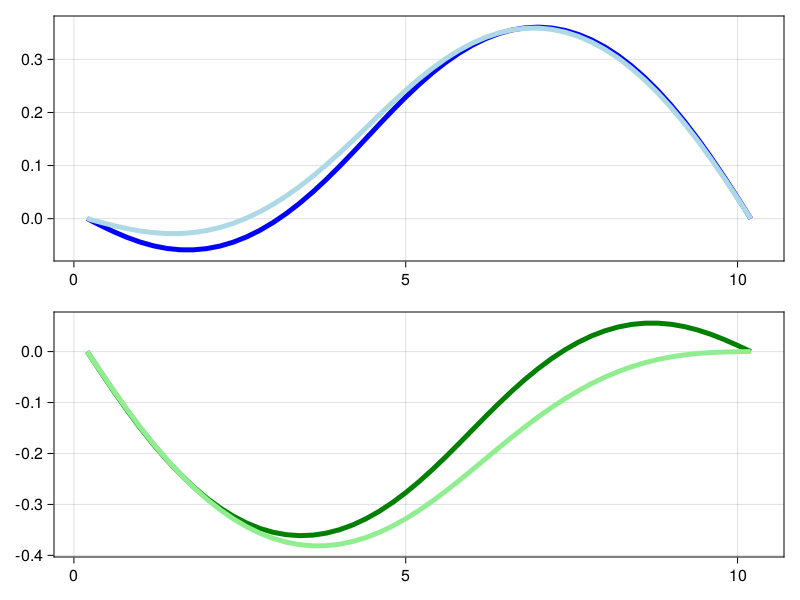

In [12]:
f = Figure()
ax1 = Axis(f[1, 1])
ax2 = Axis(f[2, 1])
ts = accumulate(+, timesteps(dual_p.trajectory))
lines!(ax1, ts, dual_p.trajectory[:a][1, :], color=:blue, linewidth=5)
lines!(ax1, ts, dual_p.trajectory[:a][3, :], color=:lightblue, linewidth=5)

lines!(ax2, ts, dual_p.trajectory[:a][2, :], color=:green, linewidth=5)
lines!(ax2, ts, dual_p.trajectory[:a][4, :], color=:lightgreen, linewidth=5)
f

In [13]:
solve!(dual_p; max_iter=100)
println("Infidelity: $(1 - unitary_fidelity(dual_p))")

Total number of variables............................:     2204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2000
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0




Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   3.7887144714798794e-02    3.7887144714798794e-02
Dual infeasibility......:   1.2929652481528000e-03    1.2929652481528000e-03
Constraint violation....:   3.2317787013180777e-07    3.2317787013180777e-07
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000000000000002e-04    1.0000000000000002e-04
Overall NLP error.......:   1.2929652481528000e-03    1.2929652481528000e-03


Number of objective function evaluations             = 143
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 143
Number of inequality constraint evaluations          = 143
Number of equality constraint Jacobian evaluations   = 101
Number of inequality constraint Jacobian evaluations = 101
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT

After optimization.

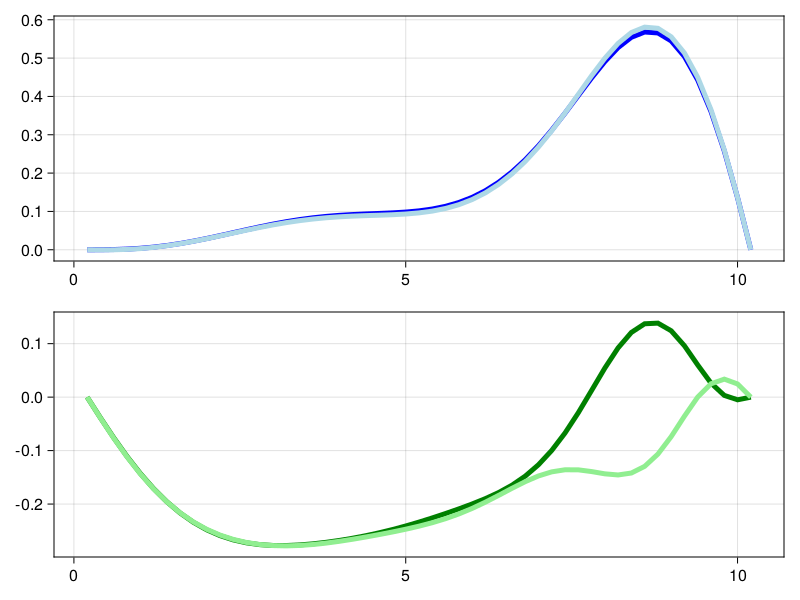

In [14]:
f = Figure()
ax1 = Axis(f[1, 1])
ax2 = Axis(f[2, 1])
ts = accumulate(+, timesteps(dual_p.trajectory))
lines!(ax1, ts, dual_p.trajectory[:a][1, :], color=:blue, linewidth=5)
lines!(ax1, ts, dual_p.trajectory[:a][3, :], color=:lightblue, linewidth=5)

lines!(ax2, ts, dual_p.trajectory[:a][2, :], color=:green, linewidth=5)
lines!(ax2, ts, dual_p.trajectory[:a][4, :], color=:lightgreen, linewidth=5)
f

# Three points

In [15]:
# index1 = length(initial_θs) -3 
index1 = length(initial_θs) ÷ 2 
index2 = length(initial_θs) ÷ 2 + 1
index3 = length(initial_θs) ÷ 2 + 2
problem1 = initial_probs[index1]
problem2 = initial_probs[index2]
problem3 = initial_probs[index3]

println("Co-optimizing $(initial_θs[index1] / π)π, $(initial_θs[index2] / π)π, and $(initial_θs[index3] / π)π...\n")

# Ipopt options
ops = Options()
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1e-2
ops.print_level = 3

trip_p = UnitaryDirectSumProblem(
    [problem1, problem2, problem3], 0.9999,
    Q=1.0,
    R=1e-2,
    pade_order=10,
    hessian_approximation=true,
    calculate_pade_operators_structure=true,
    ipopt_options=ops,
)

Co-optimizing 0.8888888888888888π, 1.1111111111111112π, and 1.3333333333333333π...



    building dynamics from integrators...
        constructing knot point dynamics functions...
        computing jacobian structure...
            computing jacobian structure for UnitaryPadeIntegrator{Float64}...
                defining variables
                computing G
                computing sum of powers
                returning sparsity structure
            computing jacobian structure for DerivativeIntegrator...
            computing jacobian structure for DerivativeIntegrator...
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 2.16e-5 = 0.0011015999999999999 GB
        determining dynamics derivative structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(91) … MOI.VariableIndex(4411) MOI.VariableIndex(4501); MOI.VariableIndex(2) MOI.VariableIndex(92) … MOI.VariableIndex(4412) MOI.VariableIndex(4502); … ; MOI.VariableIndex(89) MOI.VariableIndex(179) … MOI.VariableIndex(4499) MOI.VariableIndex(4589); MOI.VariableIndex(90) MOI.VariableIndex(180) … MOI.VariableIndex(4500) MOI.VariableIndex(4590)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 6, 6), sparse(Int64[], Int64[], Float64[], 6, 6), SparseMatrixCSC{Float64, Int64}[sparse([2, 1], [1, 2], [1.0, 1.0], 6, 6), sparse(Int64[], Int64[], Float64[], 6, 6), sparse([4, 3], [3, 4], [1.0, 1.0], 6, 6), sparse(Int64[], Int64[], Float64[], 6, 6), sparse([6, 5], [5, 6], [1.0, 1.0], 6, 6), sparse(Int64[], Int64[], Float64[], 6, 6)], SparseMatrixCSC{Float64, Int64}[sparse(Int64[], Int64[], Float64[], 6, 6), sparse([2, 1], [1, 2], [-1.0, 1.0], 6, 6), sparse(Int64[], Int64[], Float

# index1 = length(initial_θs) -3 
index1 = length(initial_θs) ÷ 2 
index2 = length(initial_θs) ÷ 2 + 1
index3 = length(initial_θs) ÷ 2 + 2

println("Co-optimizing $(initial_θs[index1] / π)π, $(initial_θs[index2] / π)π, and $(initial_θs[index3] / π)π...\n")

problem1 = initial_probs[index1]
problem2 = initial_probs[index2]
problem3 = initial_probs[index3]

trio_sys = problem1.system ⊕ problem2.system ⊕ problem3.system
trio_traj = problem1.trajectory ⊕ problem2.trajectory ⊕ problem3.trajectory

a_init = vcat(problem1.trajectory[:a], problem2.trajectory[:a], problem3.trajectory[:a])

# Construct integrators
trio_integ = [
    # UnitaryPadeIntegrator(dual_sys, :Ũ⃗, :a, order=10, autodiff=false),
    UnitaryPadeIntegrator(:Ũ⃗, :a, trio_traj, trio_sys;
        order=10,
        autodiff=false,
        calculate_pade_operators_structure=true,
        G_function=nothing,
    ),
    DerivativeIntegrator(:a, :da, trio_traj),
    DerivativeIntegrator(:da, :dda, trio_traj),
]

# Rebuild trajectory constraints
build_trajectory_constraints = true
trio_constr = AbstractConstraint[]

final_fidelity = 0.9999
fidelity_constraint = FinalUnitaryFidelityConstraint(
    :Ũ⃗,
    final_fidelity,
    trio_traj,
    hessian=false
)
push!(trio_constr, fidelity_constraint)

# Build the objective function
R = 1e-3
trio_J = UnitaryTrioQuadraticRegularizer(trio_traj, 1)
# trio_J += UnitaryInfidelityObjective(:Ũ⃗, trio_traj, .01)
trio_J += QuadraticRegularizer(:a, trio_traj, R)
trio_J += QuadraticRegularizer(:da, trio_traj, R)
trio_J += QuadraticRegularizer(:dda, trio_traj, R)

# Ipopt options
ops = Options()
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1e-3
ops.print_level = 5
ops.hessian_approximation = "limited-memory"

trip_p = QuantumControlProblem(
    trio_sys,
    trio_traj,
    trio_J,
    trio_integ;
    a_guess=a_init,
    constraints=trio_constr,
    verbose=false,
    ipopt_options=ops,
    hessian_approximation=true,
    build_trajectory_constraints=build_trajectory_constraints,
)

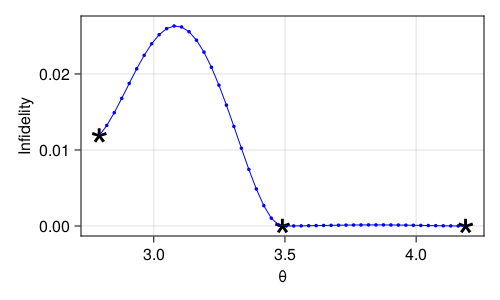

In [17]:
indices = [index1, index2, index3]

train_θs = [initial_θs[i] for i ∈ indices]
train_as = [trip_p.trajectory[:a][2*(i-1)+1:2*i, :] for i ∈ 1:length(indices)]

interp_a = Interpolations.linear_interpolation(train_θs, train_as)
interp_Θs = range(initial_θs[indices[1]], initial_θs[indices[end]], 50)
interp_a_vals = interp_a.(interp_Θs)

U1_init = problem1.trajectory.initial[:Ũ⃗]
infids = map(zip(interp_Θs, interp_a_vals)) do (θ, control)
    Ũ⃗_final = unitary_rollout(U1_init, control, Δt, system)[:, end]
    1 - unitary_fidelity(iso_vec_to_operator(Ũ⃗_final), excitation(θ))
end

train_infids = map(zip(train_θs, train_as)) do (θ, control)
    Ũ⃗_final = unitary_rollout(U1_init, control, Δt, system)[:, end]
    1 - unitary_fidelity(iso_vec_to_operator(Ũ⃗_final), excitation(θ))
end

f = Figure(resolution=(500, 300))
ax = Axis(f[1, 1], xlabel="θ", ylabel="Infidelity")#, yscale=log10)
plot!(ax, interp_Θs, infids, color=:blue, markersize=5)
plot!(ax, train_θs, train_infids, color=:black, marker='*', markersize=50)
lines!(ax, interp_Θs, infids, color=:blue, linewidth=1)
f

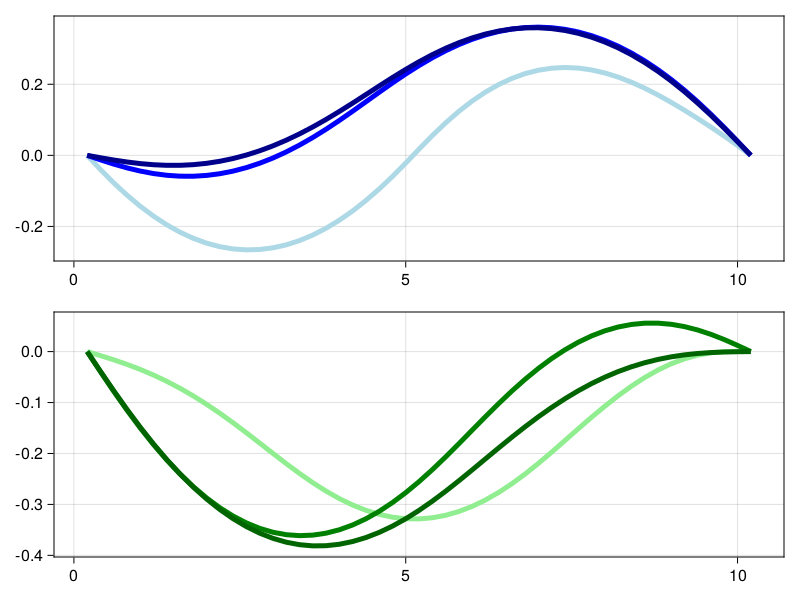

In [18]:
f = Figure()
ax1 = Axis(f[1, 1])
ax2 = Axis(f[2, 1])
ts = accumulate(+, timesteps(trip_p.trajectory))
lines!(ax1, ts, trip_p.trajectory[:a][1, :], color=:lightblue, linewidth=5)
lines!(ax1, ts, trip_p.trajectory[:a][3, :], color=:blue, linewidth=5)
lines!(ax1, ts, trip_p.trajectory[:a][5, :], color=:darkblue, linewidth=5)

lines!(ax2, ts, trip_p.trajectory[:a][2, :], color=:lightgreen, linewidth=5)
lines!(ax2, ts, trip_p.trajectory[:a][4, :], color=:green, linewidth=5)
lines!(ax2, ts, trip_p.trajectory[:a][6, :], color=:darkgreen, linewidth=5)

f

In [19]:
solve!(trip_p; max_iter=100)

Total number of variables............................:     4506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      600
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4200
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0




Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   7.8577390939617922e-02    7.8577390939617922e-02
Dual infeasibility......:   1.3495592740169031e-03    1.3495592740169031e-03
Constraint violation....:   2.7980414747386106e-06    2.7980414747386106e-06
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000316660547768e-04    1.0000316660547768e-04
Overall NLP error.......:   1.3495592740169031e-03    1.3495592740169031e-03


Number of objective function evaluations             = 127
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 127
Number of inequality constraint evaluations          = 127
Number of equality constraint Jacobian evaluations   = 101
Number of inequality constraint Jacobian evaluations = 101
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT

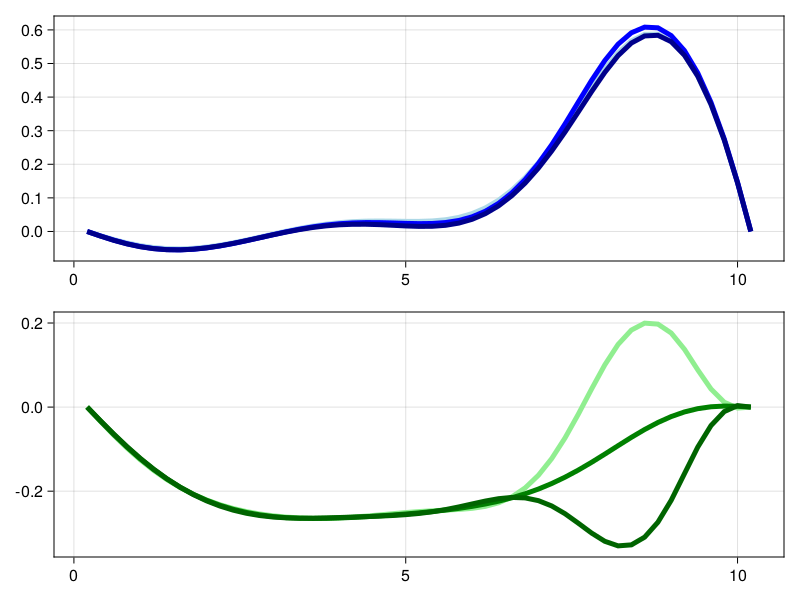

In [20]:
f = Figure()
ax1 = Axis(f[1, 1])
ax2 = Axis(f[2, 1])
ts = accumulate(+, timesteps(trip_p.trajectory))
lines!(ax1, ts, trip_p.trajectory[:a][1, :], color=:lightblue, linewidth=5)
lines!(ax1, ts, trip_p.trajectory[:a][3, :], color=:blue, linewidth=5)
lines!(ax1, ts, trip_p.trajectory[:a][5, :], color=:darkblue, linewidth=5)

lines!(ax2, ts, trip_p.trajectory[:a][2, :], color=:lightgreen, linewidth=5)
lines!(ax2, ts, trip_p.trajectory[:a][4, :], color=:green, linewidth=5)
lines!(ax2, ts, trip_p.trajectory[:a][6, :], color=:darkgreen, linewidth=5)

f

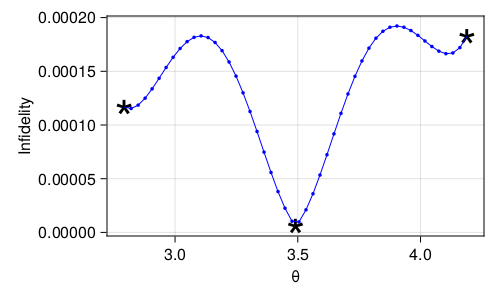

In [21]:
indices = [index1, index2, index3]

train_θs = [initial_θs[i] for i ∈ indices]
train_as = [trip_p.trajectory[:a][2*(i-1)+1:2*i, :] for i ∈ 1:length(indices)]

interp_a = Interpolations.linear_interpolation(train_θs, train_as)
interp_Θs = range(initial_θs[indices[1]], initial_θs[indices[end]], 50)
interp_a_vals = interp_a.(interp_Θs)

U1_init = problem1.trajectory.initial[:Ũ⃗]
infids = map(zip(interp_Θs, interp_a_vals)) do (θ, control)
    Ũ⃗_final = unitary_rollout(U1_init, control, Δt, system)[:, end]
    1 - unitary_fidelity(iso_vec_to_operator(Ũ⃗_final), excitation(θ))
end

train_infids = map(zip(train_θs, train_as)) do (θ, control)
    Ũ⃗_final = unitary_rollout(U1_init, control, Δt, system)[:, end]
    1 - unitary_fidelity(iso_vec_to_operator(Ũ⃗_final), excitation(θ))
end

f = Figure(resolution=(500, 300))
ax = Axis(f[1, 1], xlabel="θ", ylabel="Infidelity")#, yscale=log10)
plot!(ax, interp_Θs, infids, color=:blue, markersize=5)
plot!(ax, train_θs, train_infids, color=:black, marker='*', markersize=50)
lines!(ax, interp_Θs, infids, color=:blue, linewidth=1)
f

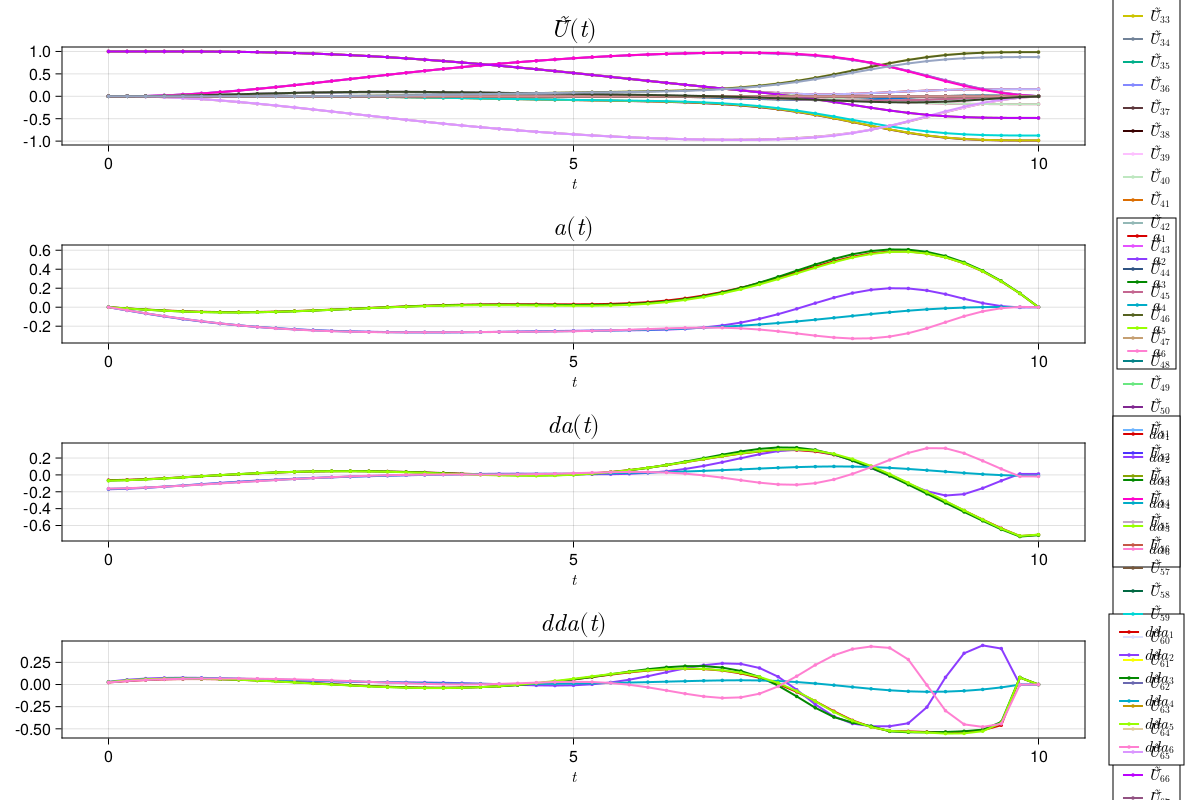

In [22]:
plot(trip_p.trajectory)

## Many more points!

In [55]:
indices = [1,2,3,4,5,6,7,8,9]
probs = [initial_probs[i] for i ∈ indices]

println("Co-optimizing ", join(["$(initial_θs[i] / π)π" for i ∈ indices], ", "))

# Ipopt options
ops = Options()
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1e-3
ops.print_level = 5

quad_p = UnitaryDirectSumProblem(
    probs, 0.9999,
    Q=1.0,
    R=1e-4,
    pade_order=10,
    hessian_approximation=true,
    calculate_pade_operators_structure=true,
    ipopt_options=ops,
)

Co-optimizing 0.0π, 0.2222222222222222π, 0.4444444444444444π, 0.6666666666666666π, 0.8888888888888888π, 1.1111111111111112π, 1.3333333333333333π, 1.5555555555555556π, 1.7777777777777777π
    building dynamics from integrators...


        constructing knot point dynamics functions...
        computing jacobian structure...
            computing jacobian structure for UnitaryPadeIntegrator{Float64}...
                defining variables
                computing G
                computing sum of powers
                returning sparsity structure


            computing jacobian structure for DerivativeIntegrator...
            computing jacobian structure for DerivativeIntegrator...
            memory estimate for stored jacobians: T * sizeof(∂f) = 51 * 0.00037584 = 0.019167840000000002 GB
        determining dynamics derivative structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(703) … MOI.VariableIndex(34399) MOI.VariableIndex(35101); MOI.VariableIndex(2) MOI.VariableIndex(704) … MOI.VariableIndex(34400) MOI.VariableIndex(35102); … ; MOI.VariableIndex(701) MOI.VariableIndex(1403) … MOI.VariableIndex(35099) MOI.VariableIndex(35801); MOI.VariableIndex(702) MOI.VariableIndex(1404) … MOI.VariableIndex(35100) MOI.VariableIndex(35802)], QuantumSystem{Float64}(sparse(Int64[], Int64[], Float64[], 18, 18), sparse(Int64[], Int64[], Float64[], 18, 18), SparseMatrixCSC{Float64, Int64}[sparse([2, 1], [1, 2], [1.0, 1.0], 18, 18), sparse(Int64[], Int64[], Float64[], 18, 18), sparse([4, 3], [3, 4], [1.0, 1.0], 18, 18), sparse(Int64[], Int64[], Float64[], 18, 18), sparse([6, 5], [5, 6], [1.0, 1.0], 18, 18), sparse(Int64[], Int64[], Float64[], 18, 18), sparse([8, 7], [7, 8], [1.0, 1.0], 18, 18), sparse(Int64[], Int64[], Float64[], 18, 18), sparse([10, 9], [9, 10], [1.0,

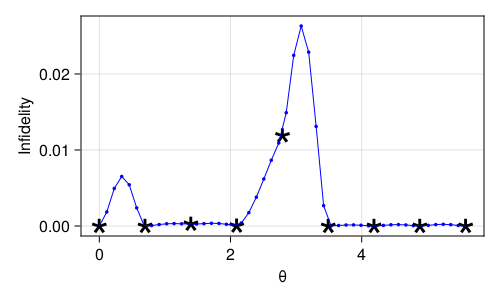

In [58]:
train_θs = [initial_θs[i] for i ∈ indices]
train_as = [quad_p.trajectory[:a][2*(i-1)+1:2*i, :] for i ∈ 1:length(indices)]

interp_a = Interpolations.linear_interpolation(train_θs, train_as)
interp_Θs = range(initial_θs[indices[1]], initial_θs[indices[end]], 50)
interp_a_vals = interp_a.(interp_Θs)

U1_init = problem1.trajectory.initial[:Ũ⃗]
infids = map(zip(interp_Θs, interp_a_vals)) do (θ, control)
    Ũ⃗_final = unitary_rollout(U1_init, control, Δt, system)[:, end]
    1 - unitary_fidelity(iso_vec_to_operator(Ũ⃗_final), excitation(θ))
end

train_infids = map(zip(train_θs, train_as)) do (θ, control)
    Ũ⃗_final = unitary_rollout(U1_init, control, Δt, system)[:, end]
    1 - unitary_fidelity(iso_vec_to_operator(Ũ⃗_final), excitation(θ))
end

f = Figure(resolution=(500, 300))
ax = Axis(f[1, 1], xlabel="θ", ylabel="Infidelity") #yscale=log10)
plot!(ax, interp_Θs, infids, color=:blue, markersize=5)
plot!(ax, train_θs, train_infids, color=:black, marker='*', markersize=50)
lines!(ax, interp_Θs, infids, color=:blue, linewidth=1)
f

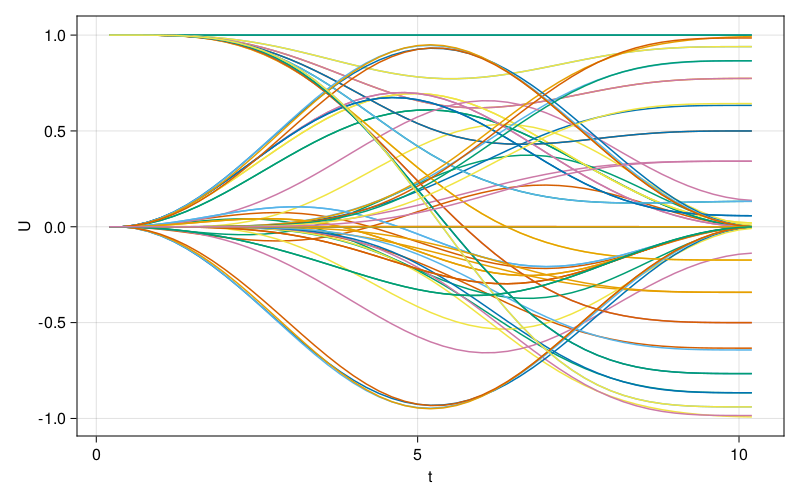

In [69]:
f = Figure(resolution=(800, 500))
ax = Axis(f[1, 1], xlabel="t", ylabel="U")
for row in eachrow(quad_p.trajectory[:Ũ⃗])
    lines!(ax, ts, row)
end
f

In [44]:
solve!(quad_p; max_iter=100)
println("Infidelity: $(1 - unitary_fidelity(quad_p))")

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   769356
Number of nonzeros in inequality constraint Jacobian.:       36
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    35118
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1800
                     variables with only upper bounds:        0
Total number of equality constraints.................:    34200
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6182165e+00 1.25e-03 2.16e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  1.5587281e+00 1.02e-03 6.41e-02  -2.3 1.80e-02    -  9.88e-01 8.87e-01h  1


   2  8.9020422e-01 1.01e-02 2.38e-01  -2.9 4.67e-01    -  9.47e-01 1.00e+00f  1


   3  7.2798980e-01 2.82e-03 5.49e-01  -3.7 1.98e-01    -  9.49e-01 7.12e-01h  1


   4  6.0080837e-01 3.36e-03 5.89e-02  -4.0 2.21e-01    -  1.00e+00 1.00e+00h  1


   5  5.5871056e-01 1.58e-03 4.08e-02  -4.0 1.51e-01    -  1.00e+00 1.00e+00h  1


   6  5.6711666e-01 9.37e-04 5.68e-02  -4.0 1.15e-01    -  1.00e+00 1.00e+00h  1


   7  5.4382668e-01 4.09e-04 4.32e-02  -4.0 8.26e-02    -  1.00e+00 1.00e+00h  1


   8  4.9190440e-01 3.27e-03 1.22e-01  -4.0 2.17e-01    -  1.00e+00 1.00e+00h  1


   9  4.2481665e-01 7.28e-03 3.49e+00  -4.0 5.03e-01    -  1.00e+00 5.44e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9225538e-01 5.15e-03 1.90e-01  -4.0 2.66e-01    -  1.00e+00 1.00e+00h  1


  11  3.3911368e-01 1.41e-03 3.73e-01  -4.1 1.87e-01    -  9.03e-01 1.00e+00h  1


  12  3.6358148e-01 1.28e-03 2.62e-02  -4.0 9.88e-02    -  1.00e+00 1.00e+00h  1


  13  3.6272124e-01 3.05e-04 1.68e-02  -4.0 8.62e-02    -  1.00e+00 1.00e+00h  1


  14  3.7899726e-01 1.26e-04 1.73e-02  -4.0 3.85e-02    -  1.00e+00 1.00e+00h  1


  15  3.8831321e-01 7.04e-05 1.72e-02  -4.0 2.53e-02    -  1.00e+00 1.00e+00h  1


  16  3.8642498e-01 1.57e-04 3.73e-02  -4.0 4.28e-02    -  1.00e+00 1.00e+00h  1


  17  3.7404015e-01 4.20e-04 3.26e-01  -4.1 1.53e-01    -  5.30e-01 6.08e-01h  1


  18  3.4709883e-01 1.95e-03 4.52e+00  -4.1 6.12e-01    -  1.17e-01 4.08e-01f  1


  19  3.2423990e-01 1.33e-03 1.27e+00  -4.1 4.04e-01    -  4.98e-01 3.63e-01h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.1626850e-01 9.47e-04 1.14e+01  -3.7 1.29e-01    -  2.36e-01 1.00e+00f  1


  21  3.0504849e-01 8.57e-04 5.63e-02  -4.0 1.58e-01    -  9.84e-01 6.57e-01h  1


  22  3.0802029e-01 1.55e-04 1.39e-02  -4.0 5.21e-02    -  1.00e+00 1.00e+00h  1


  23  3.1682309e-01 7.50e-05 2.16e-02  -4.0 3.34e-02    -  1.00e+00 1.00e+00h  1


  24  3.2225594e-01 2.20e-05 1.33e-02  -4.0 2.07e-02    -  1.00e+00 1.00e+00h  1


  25  3.2594367e-01 9.89e-06 7.02e-03  -4.0 2.04e-02    -  1.00e+00 1.00e+00h  1


  26  3.2594402e-01 5.81e-06 1.12e-02  -4.0 3.16e-02    -  1.00e+00 1.00e+00h  1


  27  3.2135014e-01 3.11e-04 1.16e+00  -4.1 2.34e-01    -  4.86e-01 8.51e-01h  1


  28  3.1289668e-01 2.07e-04 1.54e+00  -4.1 2.25e-01    -  8.03e-01 5.16e-01f  1


  29  3.0406191e-01 1.07e-04 3.74e+00  -4.1 1.49e-01    -  7.11e-01 5.65e-01f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.0816249e-01 4.89e-05 1.81e-02  -4.0 6.05e-02    -  1.00e+00 1.00e+00h  1


  31  3.1077261e-01 2.88e-05 1.46e-02  -4.0 3.08e-02    -  1.00e+00 1.00e+00h  1


  32  3.1154454e-01 1.68e-05 9.73e-03  -4.0 2.70e-02    -  1.00e+00 1.00e+00h  1


  33  3.1308216e-01 3.58e-06 2.28e-03  -4.0 1.61e-02    -  1.00e+00 1.00e+00h  1


  34  3.1297554e-01 1.76e-06 1.13e-03  -4.0 1.85e-02    -  1.00e+00 1.00e+00h  1


  35  3.1178547e-01 1.12e-05 1.58e-02  -4.0 5.66e-02    -  1.00e+00 1.00e+00h  1


  36  3.0935692e-01 9.54e-05 8.78e-02  -4.1 1.61e-01    -  1.00e+00 8.82e-01h  1


  37  3.0722506e-01 9.82e-05 9.29e-02  -4.1 1.50e-01    -  1.00e+00 1.00e+00f  1


  38  3.0130859e-01 9.30e-05 5.83e-01  -4.0 1.12e-01    -  9.55e-01 1.00e+00h  1


  39  3.0474449e-01 6.17e-05 2.65e-02  -4.0 5.48e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.0150610e-01 4.38e-05 5.88e-03  -4.0 5.01e-02    -  1.00e+00 1.00e+00h  1


  41  3.0733237e-01 2.42e-05 7.74e-03  -4.0 2.49e-02    -  1.00e+00 1.00e+00h  1


  42  3.0815232e-01 2.98e-06 1.45e-03  -4.0 7.20e-03    -  1.00e+00 1.00e+00h  1


  43  3.0884282e-01 5.86e-07 7.03e-04  -4.0 8.35e-03    -  1.00e+00 1.00e+00h  1


  44  3.0905010e-01 9.23e-08 6.46e-04  -4.0 6.06e-03    -  1.00e+00 1.00e+00h  1


  45  3.0941679e-01 2.09e-05 2.49e-02  -4.0 9.83e-02    -  1.00e+00 1.00e+00h  1


  46  3.0798833e-01 3.39e-05 5.38e-02  -4.1 1.04e-01    -  1.00e+00 1.00e+00h  1


  47  3.0539739e-01 3.02e-05 3.15e-02  -4.1 6.14e-02    -  1.00e+00 1.00e+00h  1


  48  3.0342613e-01 3.62e-05 8.82e-03  -4.1 4.84e-02    -  1.00e+00 1.00e+00h  1


  49  3.0755168e-01 7.98e-06 7.06e-03  -4.0 5.02e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.0743487e-01 5.64e-06 1.81e-03  -4.1 7.89e-03    -  1.00e+00 1.00e+00h  1


  51  3.0805129e-01 2.24e-06 4.74e-04  -4.0 5.54e-03    -  1.00e+00 1.00e+00h  1


  52  3.0838710e-01 9.15e-08 3.67e-04  -4.0 5.47e-03    -  1.00e+00 1.00e+00h  1


  53  3.0839536e-01 2.87e-07 5.05e-04  -4.0 1.27e-02    -  1.00e+00 1.00e+00h  1


  54  3.0926949e-01 2.82e-07 6.11e-03  -4.1 8.65e-02    -  1.00e+00 1.00e+00H  1


  55  3.0624018e-01 7.49e-06 1.93e-02  -4.1 1.09e-02    -  1.00e+00 1.00e+00h  1


  56  3.0741625e-01 3.49e-06 3.97e-04  -4.0 2.43e-02    -  1.00e+00 1.00e+00h  1


  57  3.0803000e-01 8.17e-07 1.62e-03  -4.0 5.48e-03    -  1.00e+00 1.00e+00h  1


  58  3.0801686e-01 2.61e-07 3.38e-04  -4.0 1.17e-02    -  1.00e+00 1.00e+00h  1


  59  3.0810075e-01 2.29e-06 1.15e-03  -4.0 3.59e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0726668e-01 1.72e-05 2.12e-02  -4.1 9.38e-02    -  1.00e+00 1.00e+00h  1


  61  3.0575158e-01 3.61e-05 3.88e-02  -4.1 1.12e-01    -  1.00e+00 1.00e+00h  1


  62  3.0562002e-01 2.46e-05 1.95e-02  -4.1 7.23e-02    -  1.00e+00 1.00e+00h  1


  63  3.0360475e-01 1.35e-05 5.06e-03  -4.1 1.32e-02    -  1.00e+00 1.00e+00h  1


  64  3.0646140e-01 8.03e-06 9.95e-04  -4.0 2.74e-02    -  1.00e+00 1.00e+00h  1


  65  3.0690304e-01 1.12e-06 1.39e-03  -4.0 1.06e-02    -  1.00e+00 1.00e+00h  1


  66  3.0704538e-01 5.22e-07 6.24e-04  -4.0 4.88e-03    -  1.00e+00 1.00e+00h  1


  67  3.0717164e-01 1.41e-07 3.99e-04  -4.0 2.14e-03    -  1.00e+00 1.00e+00h  1


  68  3.0725364e-01 3.30e-10 4.05e-04  -4.0 3.79e-03    -  1.00e+00 1.00e+00H  1


  69  3.0761129e-01 5.41e-06 1.46e-01  -4.0 7.40e-02    -  1.00e+00 5.00e-01h  2


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.0679843e-01 2.74e-06 2.64e-03  -4.1 1.51e-02    -  1.00e+00 1.00e+00h  1


  71  3.0614686e-01 3.57e-06 1.75e-03  -4.1 1.45e-02    -  1.00e+00 1.00e+00h  1


  72  3.0743529e-01 3.33e-07 3.65e-04  -4.0 2.31e-02    -  1.00e+00 1.00e+00H  1


  73  3.0667166e-01 4.35e-06 1.53e-03  -4.1 1.15e-02    -  1.00e+00 1.00e+00h  1


  74  3.0728236e-01 4.62e-06 5.94e-03  -4.0 3.27e-02    -  1.00e+00 1.00e+00h  1


  75  3.0763919e-01 1.70e-06 4.50e-03  -4.1 2.28e-02    -  1.00e+00 1.00e+00H  1


  76  3.0565496e-01 3.83e-06 4.74e-04  -4.1 9.13e-03    -  1.00e+00 1.00e+00h  1


  77  3.0730495e-01 8.83e-08 5.43e-04  -4.0 1.91e-02    -  1.00e+00 1.00e+00H  1


  78  3.0656878e-01 1.90e-06 2.07e-03  -4.1 9.12e-03    -  1.00e+00 1.00e+00h  1


  79  3.0726905e-01 2.25e-06 1.16e-03  -4.0 1.43e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.0624828e-01 8.26e-06 1.11e-02  -4.1 1.47e-02    -  1.00e+00 1.00e+00h  1


  81  3.0586502e-01 2.93e-06 2.76e-04  -4.1 7.73e-03    -  1.00e+00 1.00e+00h  1


  82  3.0731848e-01 4.81e-08 2.78e-04  -4.0 1.77e-02    -  1.00e+00 1.00e+00H  1


  83  3.0622629e-01 4.93e-06 9.44e-03  -4.1 1.40e-02    -  1.00e+00 1.00e+00h  1


  84  3.0574902e-01 2.44e-06 3.92e-04  -4.1 8.06e-03    -  1.00e+00 1.00e+00h  1


  85  3.0749481e-01 1.77e-07 8.38e-04  -4.0 2.30e-02    -  1.00e+00 1.00e+00H  1


  86  3.0625164e-01 3.42e-06 5.57e-03  -4.1 1.48e-02    -  1.00e+00 1.00e+00h  1


  87  3.0569337e-01 2.78e-06 2.59e-03  -4.1 1.19e-02    -  1.00e+00 1.00e+00h  1


  88  3.0601107e-01 1.51e-06 1.19e-03  -4.1 6.15e-03    -  1.00e+00 1.00e+00h  1


  89  3.0626190e-01 7.68e-07 7.51e-04  -4.1 3.69e-03    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.0716662e-01 4.48e-08 2.32e-04  -4.0 1.48e-02    -  1.00e+00 1.00e+00H  1


  91  3.0760672e-01 5.47e-06 1.16e-02  -4.0 3.22e-02    -  1.00e+00 1.00e+00h  1


  92  3.0564827e-01 8.22e-06 6.01e-03  -4.1 2.62e-02    -  1.00e+00 1.00e+00h  1


  93  3.0593253e-01 7.86e-06 1.84e-02  -4.1 1.13e-02    -  1.00e+00 1.00e+00h  1


  94  3.0485745e-01 5.43e-06 2.73e-04  -4.1 1.02e-02    -  1.00e+00 1.00e+00h  1


  95  3.0724161e-01 1.23e-07 4.72e-04  -4.0 2.19e-02    -  1.00e+00 1.00e+00H  1


  96  3.0641967e-01 6.35e-06 1.16e-02  -4.1 1.22e-02    -  1.00e+00 1.00e+00h  1


  97  3.0547041e-01 3.18e-06 3.71e-04  -4.1 1.39e-02    -  1.00e+00 1.00e+00h  1


  98  3.0744094e-01 1.44e-07 5.49e-04  -4.0 2.07e-02    -  1.00e+00 1.00e+00H  1


  99  3.0617884e-01 4.25e-06 6.86e-03  -4.1 1.53e-02    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0557978e-01 1.85e-06 1.32e-03  -4.1 5.20e-03    -  1.00e+00 1.00e+00h  1



Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   3.0557977972759792e-01    3.0557977972759792e-01
Dual infeasibility......:   1.3208594227642342e-03    1.3208594227642342e-03
Constraint violation....:   1.8518667629363605e-06    1.8518667629363605e-06
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.0223712404361178e-05    8.0223712404361178e-05
Overall NLP error.......:   1.3208594227642342e-03    1.3208594227642342e-03


Number of objective function evaluations             = 117
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 117
Number of inequality constraint evaluations          = 117
Number of equality constraint Jacobian evaluations   = 101
Number of inequality constraint Jacobian evaluations = 101
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT

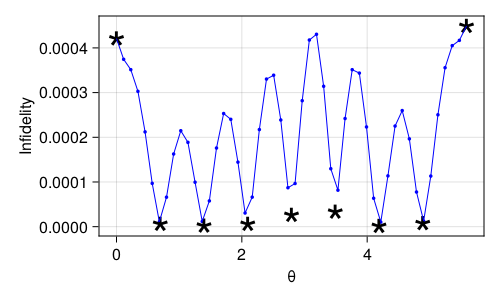

In [45]:
train_θs = [initial_θs[i] for i ∈ indices]
train_as = [quad_p.trajectory[:a][2*(i-1)+1:2*i, :] for i ∈ 1:length(indices)]

interp_a = Interpolations.linear_interpolation(train_θs, train_as)
interp_Θs = range(initial_θs[indices[1]], initial_θs[indices[end]], 50)
interp_a_vals = interp_a.(interp_Θs)

U1_init = problem1.trajectory.initial[:Ũ⃗]
infids = map(zip(interp_Θs, interp_a_vals)) do (θ, control)
    Ũ⃗_final = unitary_rollout(U1_init, control, Δt, system)[:, end]
    1 - unitary_fidelity(iso_vec_to_operator(Ũ⃗_final), excitation(θ))
end

train_infids = map(zip(train_θs, train_as)) do (θ, control)
    Ũ⃗_final = unitary_rollout(U1_init, control, Δt, system)[:, end]
    1 - unitary_fidelity(iso_vec_to_operator(Ũ⃗_final), excitation(θ))
end

f = Figure(resolution=(500, 300))
ax = Axis(f[1, 1], xlabel="θ", ylabel="Infidelity")#, yscale=log10)
plot!(ax, interp_Θs, infids, color=:blue, markersize=5)
plot!(ax, train_θs, train_infids, color=:black, marker='*', markersize=50)
lines!(ax, interp_Θs, infids, color=:blue, linewidth=1)
f

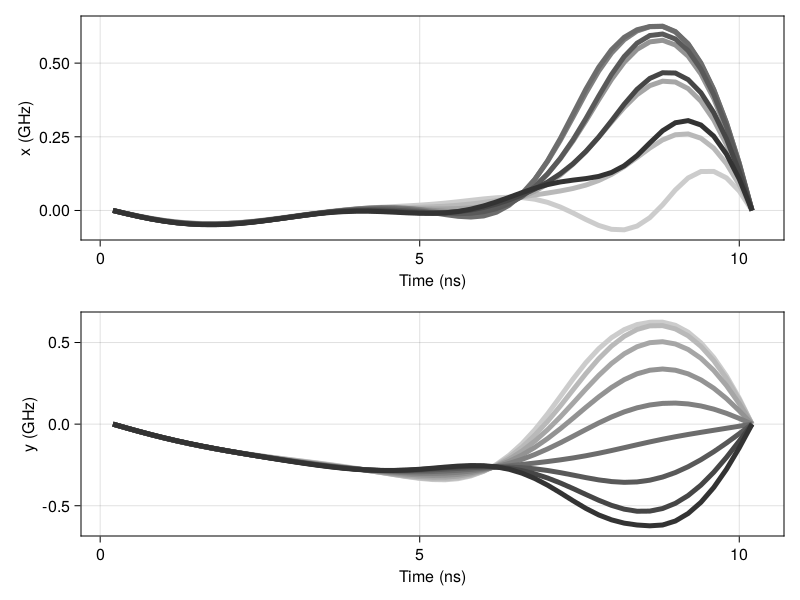

In [51]:
f = Figure()
ax1 = Axis(f[1, 1], xlabel="Time (ns)", ylabel="x (GHz)")
ax2 = Axis(f[2, 1], xlabel="Time (ns)", ylabel="y (GHz)")
colors = reverse([HSV(0.0, 0.0, i) for i in range(0.2, 0.8, length(indices))])
ts = accumulate(+, timesteps(quad_p.trajectory))
for i in indices
    lines!(ax1, ts, train_as[i][1, :], color=colors[i], linewidth=5)
end
for i in indices
    lines!(ax2, ts, train_as[i][2, :], color=colors[i], linewidth=5)
end
f

In [67]:
traj = load_traj("playground/AndySamples/interp_9pts.jld2")

NamedTrajectory{Float64}([1.0 1.0 … 0.99872141993383 0.9995815616127978; 0.0 -6.369820698066344e-30 … 0.03682083089468309 0.004731514750371882; … ; 0.014894924206624062 0.026378423011401482 … 0.005282172584024366 1.5692058018156343e-9; 0.015023894599591926 0.024619975453862252 … -0.027953232898182058 1.2501868415889988e-10], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -8.514390645964656e-7, -4.6431743767963434e-7, 3.8766600445566863e-10, 2.7105662625485646e-10, -3.778607061185941e-7, -2.9812307279555187e-7, 9.536028241471176e-9, 3.6354726538652166e-9, 1.5692058018156343e-9, 1.2501868415889988e-10], 51, 0.2, 702, (Ũ⃗ = 648, a = 18, da = 18, dda = 18, states = 684, controls = 18), (a = ([-0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -0.6283185307179586, -

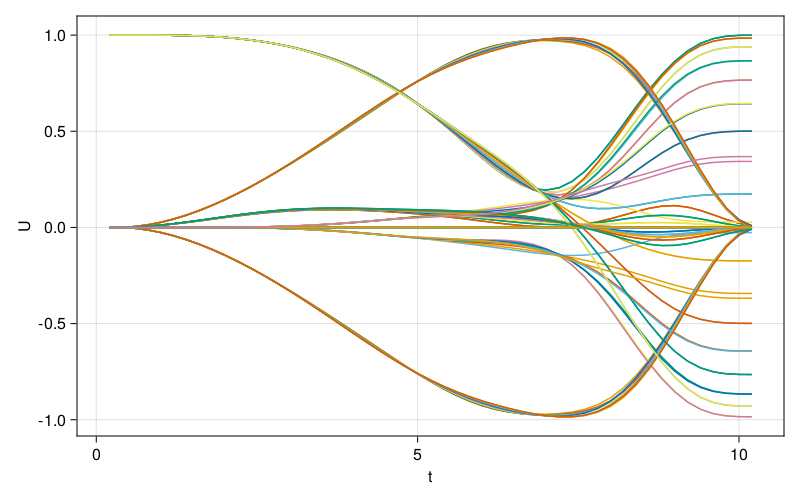

In [70]:
f = Figure(resolution=(800, 500))
ax = Axis(f[1, 1], xlabel="t", ylabel="U")
for row in eachrow(traj[:Ũ⃗])
    lines!(ax, ts, row)
end
f

### Splines

Should we do anything with splines? Unlikely because they do not handle points with unequal spacing. Perhaps a different interpolation library is appropriate...

In [ ]:
# Splines require regular grids and 1D (independet) variables
Δθ = train_θs[2] - train_θs[1]

A = [as[1, end ÷ 2] for as ∈ train_as]
scale(interpolate(A, BSpline(Cubic())), 0:Δθ:train_θs[end])
# interpolate(0:Δθ:train_θs[end], A, BSpline(Cubic()))


function cubic_interpolation(
    θ_init::Real,
    θ_final::Real,
    Δθ::Real,
    θas::AbstractVector{<:AbstractMatrix{<:Real}}
)
    matrix = []
    for a in 1:size(θas[1], 1)
        row = []
        for t in 1:size(θas[1], 2)
            A = [as[a, t] for as ∈ θas]
            interp = scale(interpolate(A, BSpline(Cubic())), θ_init:Δθ:θ_final)
            push!(row, interp)
        end
        push!(matrix, row)
    end
    return stack(matrix, dims=1)
end